In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import pathlib
%matplotlib inline

In [2]:
os.getcwd()

'c:\\Users\\Inkyu Yang\\20242402\\emotion_analysis'

### Data Loading and Preprocessing

In [3]:
# 경로 설정
data_dir = pathlib.Path('./img')
train_dir = data_dir / 'train'
#train_angry = train_dir / 'angry'
#train_disgusted = train_dir / 'disgusted'
#train_fearful = train_dir / 'fearful'
#train_happy = train_dir / 'happy'
#train_neutral = train_dir / 'neutral'
#train_sad = train_dir / 'sad'
#train_surprised = train_dir / 'surprised'

test_dir = data_dir / 'test'
#test_angry = test_dir / 'angry'
#test_disgusted = test_dir / 'disgusted'
#test_fearful = test_dir / 'fearful'
#test_happy = test_dir / 'happy'
#test_neutral = test_dir / 'neutral'
#test_sad = test_dir / 'sad'
#test_surprised = test_dir / 'surprised'

In [4]:
list(train_dir.glob('*/*'))
print(np.array(list(train_dir.glob('*/*'))), '\n')
list(test_dir.glob('*/*.png'))
print(np.array(list(test_dir.glob('*/*.png'))))

[WindowsPath('img/train/angry/im0.png')
 WindowsPath('img/train/angry/im1.png')
 WindowsPath('img/train/angry/im10.png') ...
 WindowsPath('img/train/surprised/im997.png')
 WindowsPath('img/train/surprised/im998.png')
 WindowsPath('img/train/surprised/im999.png')] 

[WindowsPath('img/test/angry/im0.png')
 WindowsPath('img/test/angry/im1.png')
 WindowsPath('img/test/angry/im10.png') ...
 WindowsPath('img/test/surprised/im97.png')
 WindowsPath('img/test/surprised/im98.png')
 WindowsPath('img/test/surprised/im99.png')]


In [5]:
train_image_paths = list(train_dir.glob('*/*'))
test_image_paths = list(test_dir.glob('*/*'))

In [6]:
print("Train set length: ", len(train_image_paths))
print("Test set length: ", len(test_image_paths))
# Train 75 : Test 25 ratio

Train set length:  28709
Test set length:  7178


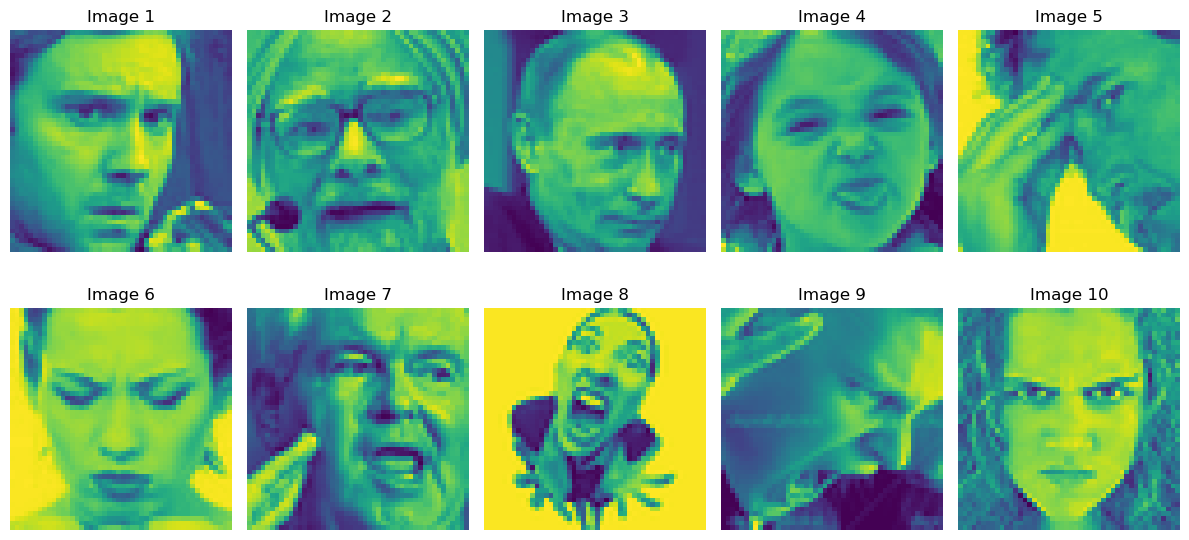

In [7]:
# For test
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(0, 10):
    img = PIL.Image.open(train_image_paths[i])
    axes[i].imshow(img)
    axes[i].axis('off')  # 축 숨기기
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [8]:
# Pixel size: 48x48
batch_size = 32
img_size = (48, 48)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  labels='inferred',
  label_mode='categorical',
  subset="training",
  seed=42,
  image_size=(img_size[0], img_size[1]),
  batch_size=batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    subset="validation",
    seed=42,
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False # 검증 데이터는 일반적으로 셔플링하지 않음
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False, # 테스트 데이터는 일반적으로 셔플링하지 않음
    seed=42      # 재현성을 위해 seed 설정 (데이터 순서에 영향 없음)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [9]:
print(train_ds.class_names)
print(test_ds.class_names)

class_names = train_ds.class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


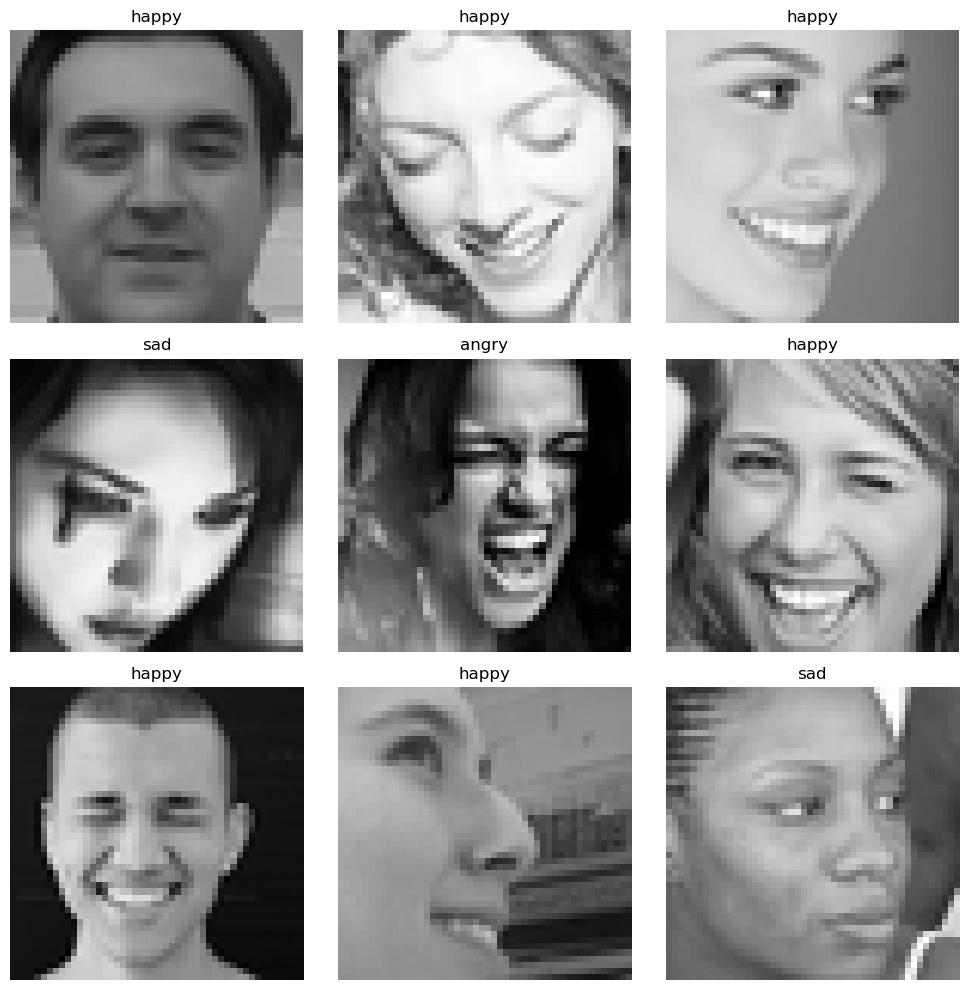

In [10]:
# 데이터셋 이미지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [11]:
# 이미지 구조
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

(32, 48, 48, 3)
(32, 7)


In [12]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(718, shape=(), dtype=int64)
tf.Tensor(180, shape=(), dtype=int64)
tf.Tensor(225, shape=(), dtype=int64)


In [13]:
# 데이터 로딩 병목 완화
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [14]:
# RGB Channel Range 1 to 255. Therefore, it needs to be rescaled.
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  # lambda Function for Normalization
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))

# To adjust pixel values to [-1, 1]
# tf.keras.layers.Rescaling(1./127.5, offset=-1)

# normalized_train_ds = train_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
# normalized_val_ds = val_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
# normalized_test_ds = test_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))


0.023529414 0.91372555


### Neural Network

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [ ]:
simple_model = tf.keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 3)), 
    layers.Rescaling(1./255),  # 입력 이미지 픽셀 값 정규화
    layers.Flatten(),  # 1D 벡터 변환
    layers.Dense(128, activation='relu'),  # Hidden Layer, Fully Connected Layer
    layers.Dense(len(class_names), activation='softmax')  # Output Layer, 다중분류
])

simple_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

simple_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 128)            │       884,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,767 (3.38 MB)

 Trainable params: 885,767 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [208]:
history = simple_model.fit(train_ds, epochs=10, batch_size=32, validation_data=val_ds)

Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2434 - loss: 2.0430 - val_accuracy: 0.3001 - val_loss: 2.1472
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3037 - loss: 1.7455 - val_accuracy: 0.2021 - val_loss: 2.0843
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3211 - loss: 1.7148 - val_accuracy: 0.2097 - val_loss: 1.8940
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3256 - loss: 1.6995 - val_accuracy: 0.2399 - val_loss: 1.8907
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3339 - loss: 1.6943 - val_accuracy: 0.2358 - val_loss: 1.9760
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.3449 - loss: 1.6759 - val_accuracy: 0.2719 - val_loss: 1.8688
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3484 - loss: 1.6690 - val_accuracy: 0.3994 - val_loss: 1.6236
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3527 - loss: 1.6589 - 

In [209]:
# Simple Model 평가
test_loss, test_accuracy = simple_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2248 - loss: 1.7500
Test Loss: 1.6644339561462402
Test Accuracy: 0.35511285066604614


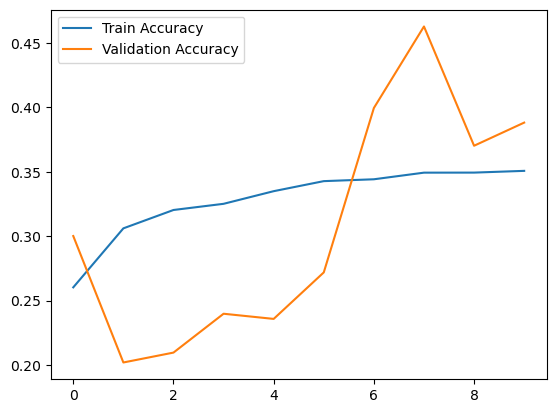

In [210]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
# CNN 모델
cnn_model = tf.keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 3)),   # Input Layer
    layers.Rescaling(1./255),   # Rescaling Layer, 정규화
    
    layers.Conv2D(32, (3, 3), activation='relu'),    # 1st Convolutional Layer, 32 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),    # 2nd Convolutional Layer, 64 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.25),
    
    layers.Flatten(), # Flatten Layer, 1차원 벡터로 변환
    layers.Dense(128, activation='relu'),   # Dense Layer
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(len(class_names), activation='softmax') # Dense Layer, Output Layer
])

# 최적화 알고리즘, 손실 함수 설정, 평가 지표
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,519 (3.21 MB)

 Trainable params: 840,071 (3.20 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
# 모델 학습
history = cnn_model.fit(train_ds, epochs=10, batch_size=32, validation_data=val_ds)

Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3049 - loss: 1.9660 - val_accuracy: 0.4454 - val_loss: 1.7374
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.4300 - loss: 1.4944 - val_accuracy: 0.4625 - val_loss: 19.0554
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.4638 - loss: 1.4028 - val_accuracy: 0.3538 - val_loss: 1.9611
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.4970 - loss: 1.3228 - val_accuracy: 0.4010 - val_loss: 1.5677
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.5232 - loss: 1.2612 - val_accuracy: 0.6448 - val_loss: 1.0309
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.5462 - loss: 1.2012 - val_accuracy: 0.5698 - val_loss: 1.1384
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.5502 - loss: 1.1886 - val_accuracy: 0.3766 - val_loss: 1.8258
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.5833 - loss: 1.1066 -

In [28]:
train_loss, train_accuracy = cnn_model.evaluate(train_ds)
print(f'Test Loss: {train_loss}')
print(f'Test Accuracy: {train_accuracy}')

718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7340 - loss: 0.7811
Test Loss: 0.7448790073394775
Test Accuracy: 0.7495210766792297


In [29]:
val_loss, val_accuracy = cnn_model.evaluate(val_ds)
print(f'Test Loss: {val_loss}')
print(f'Test Accuracy: {val_accuracy}')

180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7571 - loss: 0.8029
Test Loss: 0.7382147312164307
Test Accuracy: 0.7838355898857117


In [27]:
# CNN 모델 평가
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4815 - loss: 1.4314
Test Loss: 1.2810412645339966
Test Accuracy: 0.5419337153434753


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers.models.vit.modeling_tf_vit import TFViTEncoder
from transformers import ViTConfig

# 이미지 크기 및 클래스 개수 (실제 클래스 개수로 변경 필요)
img_size = (48, 48)
num_classes = 7  # 예시: 감정 분류 클래스 개수

# CNN 백본 정의
cnn_backbone = keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    # CNN 백본의 출력을 Transformer 인코더의 입력으로 변환하기 위한 레이어
    layers.Conv2D(projection_dim, 1) # 1x1 컨볼루션으로 채널 수 조정 (Transformer의 hidden_size)
])

# Dummy 입력 생성 및 CNN 백본 호출
dummy_input = tf.random.normal(shape=(16, img_size[0], img_size[1], 3)) # 배치 크기 명시
cnn_output = cnn_backbone(dummy_input)

# 특징 맵의 shape 얻기
_, h, w, c = cnn_output.shape.as_list()

# Transformer 설정
projection_dim = 256  # Transformer의 hidden_size
num_heads = 8  # Attention head 수
num_layers = 4  # Transformer 레이어 수
patch_size = 4

# 특징 맵을 Transformer 인코더의 입력 시퀀스로 변환 (patchify)
patch_size_h = patch_size
patch_size_w = patch_size
stride_h = patch_size
stride_w = patch_size

patches = tf.image.extract_patches(
    images=cnn_output,
    sizes=[1, patch_size_h, patch_size_w, 1],
    strides=[1, stride_h, stride_w, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# 정확한 num_patches 계산
num_patches_h = h // patch_size_h
num_patches_w = w // patch_size_w
num_patches = num_patches_h * num_patches_w

patches_reshaped = tf.reshape(patches, [-1, (patch_size_h * patch_size_w), c])
patch_embeddings = layers.Dense(projection_dim)(patches_reshaped)

# Reshape 레이어에 배치 크기 포함
patch_embeddings_reshaped = tf.reshape(patch_embeddings, [-1, num_patches, projection_dim])

# 위치 임베딩 추가
positional_embeddings = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(tf.range(start=0, limit=num_patches, delta=1))
transformer_input = patch_embeddings_reshaped + positional_embeddings

# Transformer 인코더 설정 생성
transformer_config = ViTConfig(
    hidden_size=projection_dim,
    num_hidden_layers=num_layers,
    num_attention_heads=num_heads,
    intermediate_size=projection_dim * 4,
    hidden_act="gelu",
    attention_probs_dropout_prob=0.1,
    hidden_dropout_prob=0.1,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
)

# Transformer 인코더 정의
transformer_encoder = TFViTEncoder(config=transformer_config)

# head_mask 초기화 (모든 헤드를 유지)
head_mask = tf.ones((num_layers, num_heads))

# Transformer 인코더 통과
transformer_output = transformer_encoder(
    transformer_input,  # 첫 번째 위치 인수로 입력 텐서 전달
    head_mask=head_mask,
    output_attentions=False,
    output_hidden_states=False,
    return_dict=False
)[0]  # TFViTEncoder는 튜플 형태로 출력을 반환할 수 있으므로 첫 번째 요소(last_hidden_state)를 선택

# 분류를 위한 처리 (예: global average pooling 후 dense layer)
pooled_output = layers.GlobalAveragePooling1D()(transformer_output)
dropout_output = layers.Dropout(0.5)(pooled_output)
output = layers.Dense(num_classes, activation='softmax')(dropout_output)

# 최종 모델 정의
hybrid_model = keras.Model(inputs=cnn_backbone.input, outputs=output)

# 모델 컴파일
hybrid_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# 모델 요약
hybrid_model.summary()

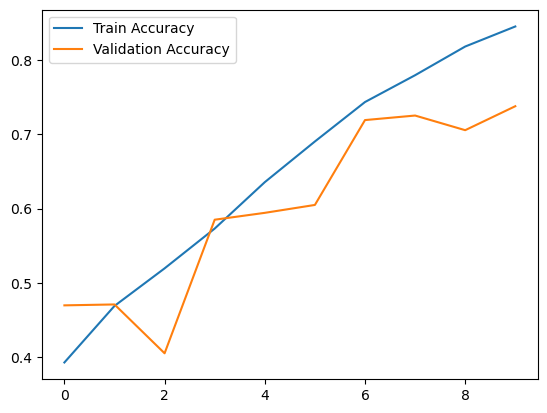

In [23]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [249]:
advanced_cnn_model = tf.keras.Sequential([
    # 입력층 추가
    keras.Input(shape=(img_size[0], img_size[1], 3)),  # 입력 크기: (48, 48, 3)

    # 데이터 증강
    tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]),
    # 정규화
    layers.Rescaling(1./255),
    # 합성곱 및 풀링 층
    layers.Conv2D(32, 3, activation='relu'),  # 이미지 국소적 특징 학습, 2D 또는 3D 텐서
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),  # 이미지 국소적 특징 학습, 2D 또는 3D 텐서
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),  # 이미지 국소적 특징 학습, 2D 또는 3D 텐서
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    # Flatten 및 Dense 층
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # 이미지 전역적 특징 학습, 1D 벡터
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

advanced_cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

advanced_cnn_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_32 (Sequential)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_25 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,319 (1.36 MB)

 Trainable params: 356,871 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [250]:
history = advanced_cnn_model.fit(train_ds, epochs=10, batch_size=32, validation_data=val_ds)

Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 119s 166ms/step - accuracy: 0.2705 - loss: 1.9247 - val_accuracy: 0.4125 - val_loss: 1.4088
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 176ms/step - accuracy: 0.3807 - loss: 1.5715 - val_accuracy: 0.5334 - val_loss: 1.3791
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 117s 164ms/step - accuracy: 0.4184 - loss: 1.4892 - val_accuracy: 0.5400 - val_loss: 1.2751
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 118s 164ms/step - accuracy: 0.4509 - loss: 1.4240 - val_accuracy: 0.5348 - val_loss: 1.2944
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 117s 163ms/step - accuracy: 0.4687 - loss: 1.3858 - val_accuracy: 0.5354 - val_loss: 1.4127
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 115s 161ms/step - accuracy: 0.4832 - loss: 1.3414 - val_accuracy: 0.5471 - val_loss: 1.3827
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 116s 161ms/step - accuracy: 0.4970 - loss: 1.3251 - val_accuracy: 0.5637 - val_loss: 1.2712
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 111s 154ms/step - accuracy: 0.5084 -

In [251]:
# 모델 평가가
test_loss, test_accuracy = advanced_cnn_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4650 - loss: 1.3689
Test Loss: 1.2885117530822754
Test Accuracy: 0.5203399062156677


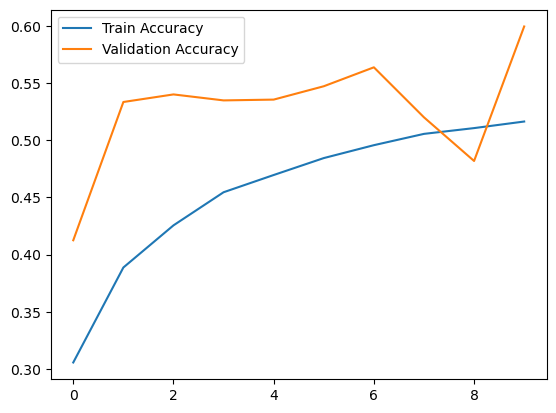

In [252]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

### Hybrid CNN-Transformer Model

#### With Pytorch

In [2]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 크기 및 전처리 정의 (ViT 모델에 맞게 224x224로 리사이즈)
img_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# 데이터 디렉토리 경로
train_dir = './img/train'
test_dir = './img/test'

# ImageFolder를 사용하여 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, data_transforms['test'])

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 이름 확인
class_names = train_dataset.classes
print("Class names:", class_names)

# 데이터 로더에서 이미지 및 레이블 확인 (선택 사항)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Class names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [3]:
import torch.nn as nn

# 사전 학습된 ViT 모델 불러오기
model = models.vit_b_16(pretrained=True)

# 마지막 분류 레이어 수정
num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, len(class_names))

# GPU 사용 가능 시 GPU로 모델 이동
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 수정된 모델 구조 확인 (선택 사항)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.train() # 학습 모드로 설정

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)  # X
        labels = labels.to(device)  # y

        optimizer.zero_grad() # 기울기 초기화

        outputs = model(inputs) # 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 역전파 (기울기 계산)
        optimizer.step() # 옵티마이저 업데이트

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/10], Step [100/898], Loss: 1.8993
Epoch [1/10], Step [200/898], Loss: 1.8143


KeyboardInterrupt: 

In [ ]:
# 테스트 루프
model.eval() # 평가 모드로 설정
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f} %')

In [261]:
import transformers
print(transformers.__version__)

4.51.3


#### Pytorch 2

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification

# 사용할 사전 학습된 ViT 모델 이름
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# 이미지 디렉토리 경로
train_dir = './img/train'
test_dir = './img/test'

# 이미지 변환 함수 정의
def transform_images(image):
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values'][0] # 배치 차원 제거

def collate_fn(batch):
    images = [transform_images(img) for img, label in batch]
    labels = torch.tensor([label for img, label in batch])
    images = torch.stack(images)
    return images, labels

# ImageFolder를 사용하여 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 클래스 이름 확인
class_names = train_dataset.classes
print("Class names:", class_names)

# 데이터 로더에서 이미지 및 레이블 확인 (선택 사항)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Class names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [8]:
from transformers import ViTForImageClassification

# num_labels 파라미터에 분류할 클래스 개수를 지정합니다.
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(class_names))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits if isinstance(model, ViTForImageClassification) else model(images).last_hidden_state[:, 0, :]
        if not isinstance(model, ViTForImageClassification):
            outputs = model.classifier(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

KeyboardInterrupt: 

### ViT (Vision Transformer)

In [87]:
# 이미지 사이즈 조정
resized_train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
resized_val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
resized_test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))

In [88]:
# 정규화 (픽셀 값을 [0, 1] 범위로 변환)
normalized_train_ds = resized_train_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
normalized_val_ds = resized_val_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
normalized_test_ds = resized_test_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))

# 또는 tf.keras.layers.Rescaling을 사용하여 [-1, 1] 범위로 정규화
# rescaling_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# normalized_train_ds = resized_train_ds.map(lambda x, y: (rescaling_layer(x), y))
# normalized_val_ds = resized_val_ds.map(lambda x, y: (rescaling_layer(x), y))
# normalized_test_ds = resized_test_ds.map(lambda x, y: (rescaling_layer(x), y))